In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from model import lorenz63

plt.style.use('seaborn')

## Nature Run (5s for spin up, 40s for nature run. dt=0.01s)

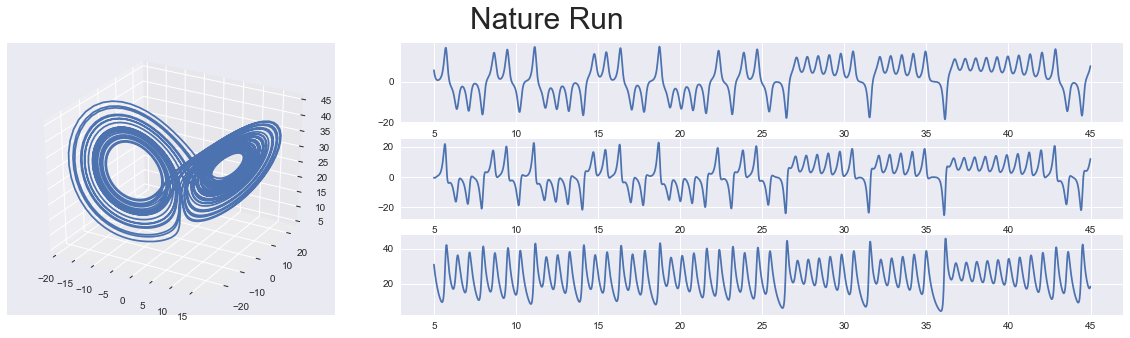

In [171]:
## X = [[x0, x1, x2, ....],
##      [y0, y1, y2, ....],
##      [z0, z1, z2, ....]]


# spin up
spinup_time = 5
dt = 0.01
#X0 = np.array([[10.1], [-0.5], [40.1]])
X0_nature = np.array([[0], [5], [30]])
result = lorenz63(X0_nature.ravel(), np.arange(0, spinup_time, dt))
X_spn = result.y

# save nature run
time = 40
dt = 0.01
ts = np.arange(spinup_time, spinup_time+time, dt)
X0 = X_spn[:,[-1]]
result = lorenz63(X0.ravel(), ts)
X_nature = result.y

# plot nature run
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(nrows=3, ncols=3)

ax_line1 = fig.add_subplot(gs[0,1:])
ax_line2 = fig.add_subplot(gs[1,1:])
ax_line3 = fig.add_subplot(gs[2,1:])
ax_3d = fig.add_subplot(gs[:,0], projection='3d')

ax_line1.plot(ts, X_nature[0,:])
ax_line2.plot(ts, X_nature[1,:])
ax_line3.plot(ts, X_nature[2,:])
ax_3d.plot(X_nature[0,:], X_nature[1,:], X_nature[2,:])

fig.suptitle('Nature Run', fontsize=30);

## Simulated Observation (Observation every 2s, total 20 assimilation cycle)

In [172]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

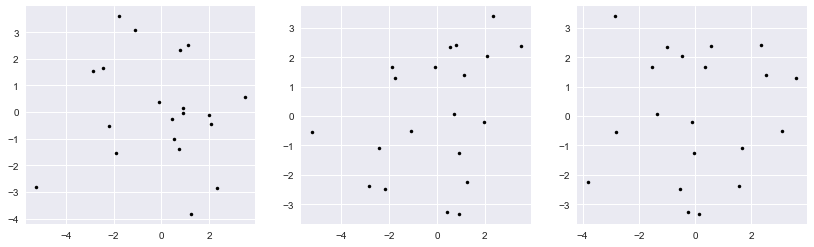

In [173]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [5, 5, 5]
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 2
cycle_num = int(time / obs_timeintv)

# construct observation error
X_obs_err = np.zeros((3, cycle_num))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_normal(obsm, obsv, cycle_num, rst)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

# plot observation errors
fig, axs = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
axs[0].plot(X_obs_err[0], X_obs_err[1], 'k.')
axs[1].plot(X_obs_err[0], X_obs_err[2], 'k.')
axs[2].plot(X_obs_err[1], X_obs_err[2], 'k.')

## Initial condition

In [174]:
# spin up and get initial condition for experiments
# random_state=9 is very close to nature run
X0 = X0_nature + gen_random_normal(0, 5, size=1, random_state=30)
result = lorenz63(X0.ravel(), np.arange(0, spinup_time, dt))
X_spn = result.y

X_ini = X_spn[:,[-1]]
X_ini

array([[-5.37015148],
       [-8.18451994],
       [18.23352007]])

#### (1) Test assimilation cycle: no assimilation

========Some Parameters=========
cycle length (time interval between two observations): 2 sec
number of cycle: 20
dt = 0.01 sec
initial value for experiment: [-5.37015148 -8.18451994 18.23352007]
initial value for nature run: [ 5.57925715 -0.43297528 30.89471364]


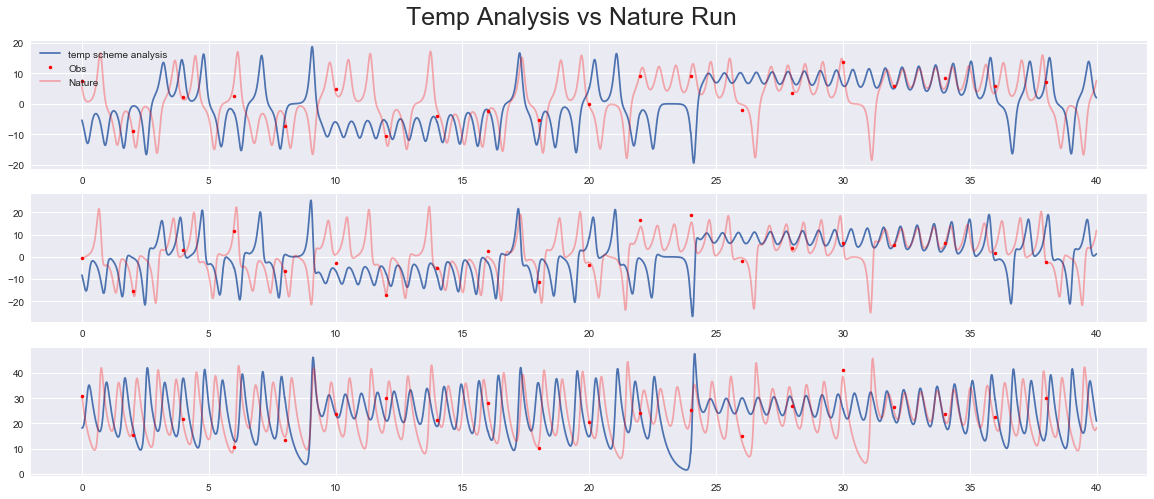

In [175]:
def temp_scheme(xb, obs, Pb, R):
    return xb, Pb


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')


cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa = temp_scheme(xb, X_obs[:,[nc]], None, None)[0]
    x = lorenz63(xa.ravel(), ts).y
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='temp scheme analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('Temp Analysis vs Nature Run', fontsize=25, y=0.94);

#### (2.1.1) OI - NMC method using nature run as reference

In [219]:
def nmc(model, ref, dt, alpha, t1, t2, num):
    result = np.zeros((num, 2, ref[:,0].size))
    interv = int((t2-t1) / dt)
    for n in range(num):
        x0 = ref[:,n*interv]
        ts = np.arange(0, t2, dt)
        xs = model(x0, ts).y
        result[n,0,:] = xs[:,int(t1/dt)]
        result[n,1,:] = xs[:,-1]
    """    
    Pb = np.zeros((x0.size, x0.size))
    diff_t2t1 = result[:,1,:] - result[:,0,:]
    for n in range(num):
        Pb += diff_t2t1[n,np.newaxis].T * diff_t2t1[n,:]
    """
    Pb = np.zeros((x0.size, x0.size))
    for n in range(1, num):
        xf_diff = result[n,0,:] - result[n-1,1,:]
        Pb += xf_diff[:,np.newaxis] * xf_diff
        
    return alpha * Pb / num

In [220]:
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
Pb = nmc(lorenz63, X_nature, dt, alpha=10, t1=1, t2=2, num=20)
Pb

array([[ 3.55388503,  5.17753847,  2.23886887],
       [ 5.17753847, 10.69676405,  3.99301979],
       [ 2.23886887,  3.99301979,  7.63994213]])

#### (2.1.2) OI - test NMC method by using nature run as reference

========Some Parameters=========
cycle length (time interval between two observations): 2 sec
number of cycle: 20
dt = 0.01 sec
initial value for experiment: [-5.37015148 -8.18451994 18.23352007]
initial value for nature run: [ 5.57925715 -0.43297528 30.89471364]


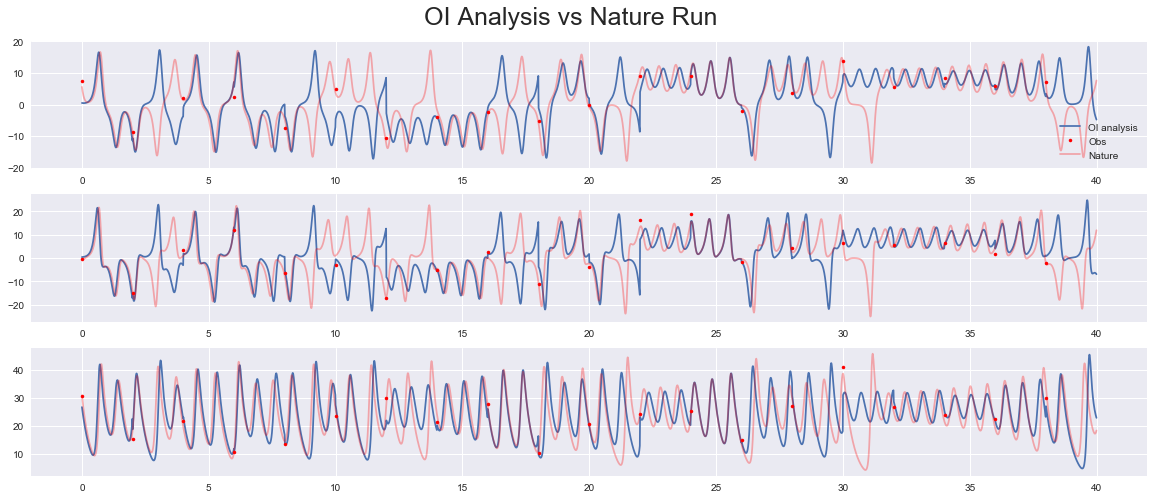

In [221]:
from assimilation_schemes import OI


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')


cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa = OI(xb, X_obs[:,[nc]], Pb, R)[0]
    x = lorenz63(xa.ravel(), ts).y
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('OI Analysis vs Nature Run', fontsize=25, y=0.94);

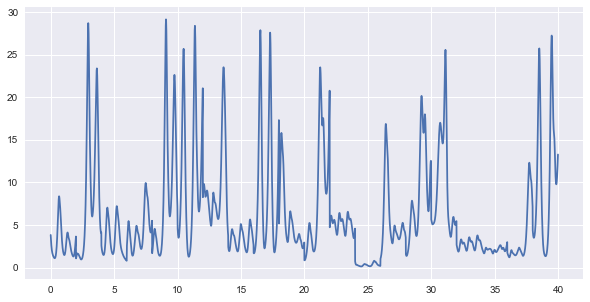

In [222]:
rmse = np.sqrt(np.mean((result-X_nature)**2, axis=0))
plt.figure(figsize=(10, 5))
plt.plot(ts, rmse)

#### (2.2.1) OI - NMC method using iterative approach

In [180]:
# observation error covariance and initial background error covariance
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
Pb = np.zeros((X_ini.size, X_ini.size))
np.fill_diagonal(Pb, obs_var)

# assimilation
cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

niter = 100
Pb_history = np.zeros((Pb.size, niter))
# ====== test iter =====
for i in range(niter):
    if i%10 == 0:
        print(f'----- i = {i} -----')
        print(Pb)
        print()
    Pb_history[:,i] = Pb.ravel()
    
    # start cycle assimilation
    for nc in range(cycle_num):
        # calculate analysis field, then forecast
        xa = OI(xb, X_obs[:,[nc]], Pb, R)[0]
        x = lorenz63(xa.ravel(), ts).y
        result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x

        # for next cycle
        xb = x[:,[-1]]
        t_start = int(ts[-1] + dt)
        ts = np.arange(t_start, t_start+cycle_len, dt)

    # use `result` (assimilation result) as reference to apply NMC
    ref = result
    Pb = nmc(lorenz63, ref, dt, alpha=1, t1=1, t2=2, num=30)

print(f'----- i = {i+1} -----')
print(Pb)

----- i = 0 -----
[[5. 0. 0.]
 [0. 5. 0.]
 [0. 0. 5.]]

----- i = 10 -----
[[ 61.2015204   75.97410023 -12.69558426]
 [ 75.97410023 100.74157057 -11.53911282]
 [-12.69558426 -11.53911282  82.52681052]]

----- i = 20 -----
[[ 62.67774631  53.85664025 -11.42488399]
 [ 53.85664025  69.4484686    7.90949741]
 [-11.42488399   7.90949741  45.55787673]]

----- i = 30 -----
[[ 80.88796419  65.78927449 -15.82922325]
 [ 65.78927449  73.76223192 -20.76103606]
 [-15.82922325 -20.76103606  34.40361108]]

----- i = 40 -----
[[56.90029324 52.32378616  3.74931438]
 [52.32378616 59.16512303 -0.46525795]
 [ 3.74931438 -0.46525795 60.41154631]]

----- i = 50 -----
[[ 54.03962713  53.42208297 -34.59978172]
 [ 53.42208297  69.06024319 -31.30136789]
 [-34.59978172 -31.30136789  46.74701097]]

----- i = 60 -----
[[ 52.62112125  56.5350364   34.61465233]
 [ 56.5350364   73.42734654  34.95142081]
 [ 34.61465233  34.95142081 119.9709268 ]]

----- i = 70 -----
[[ 57.55757903  56.16358304 -32.00552715]
 [ 56.1635

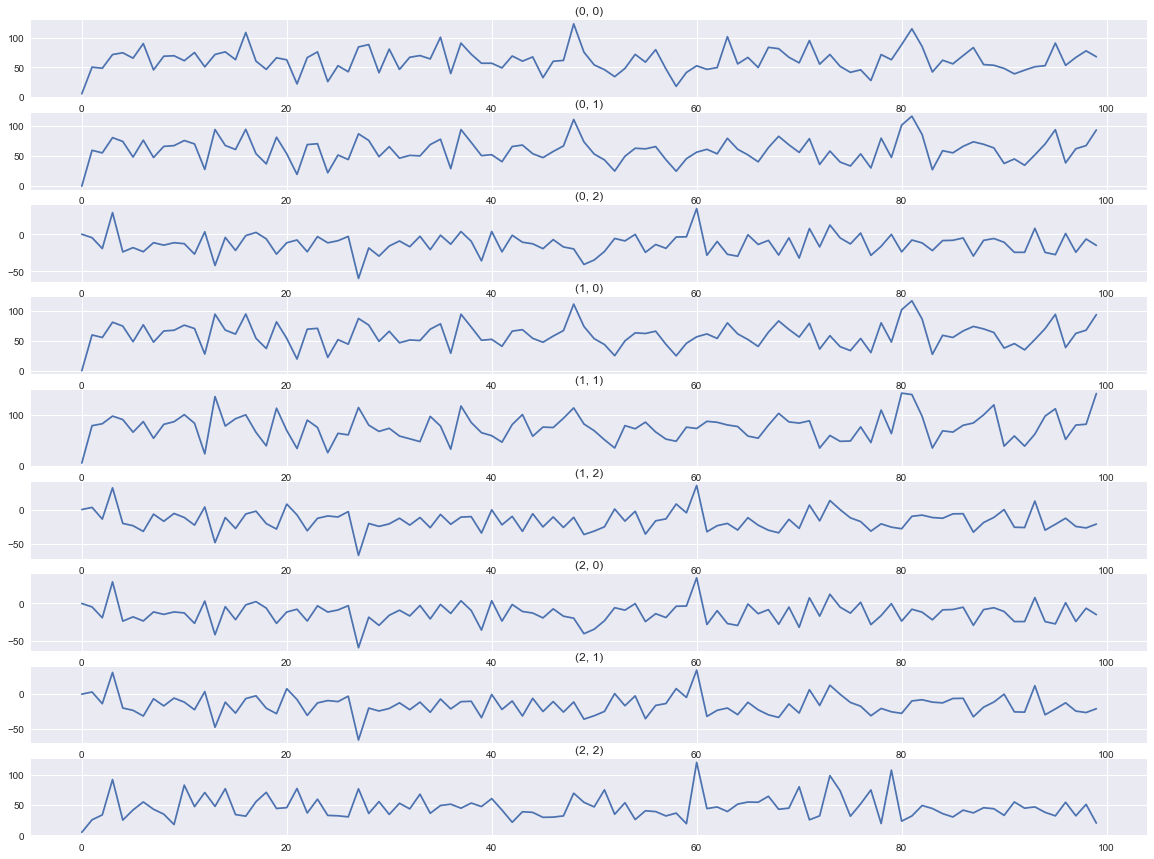

In [181]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(20, 15))
for i in range(9):
    ax[i].plot(Pb_history[i,:])
    ax[i].set_title(f'({i//3}, {i%3})')

In [182]:
Pb = Pb_history[:,int(niter/2):].mean(axis=1).reshape((3,3))
Pb

array([[ 60.79422304,  58.59531215, -12.38775834],
       [ 58.59531215,  75.64098241, -15.45633509],
       [-12.38775834, -15.45633509,  46.92962065]])

========Some Parameters=========
cycle length (time interval between two observations): 2 sec
number of cycle: 20
dt = 0.01 sec
initial value for experiment: [-5.37015148 -8.18451994 18.23352007]
initial value for nature run: [ 5.57925715 -0.43297528 30.89471364]


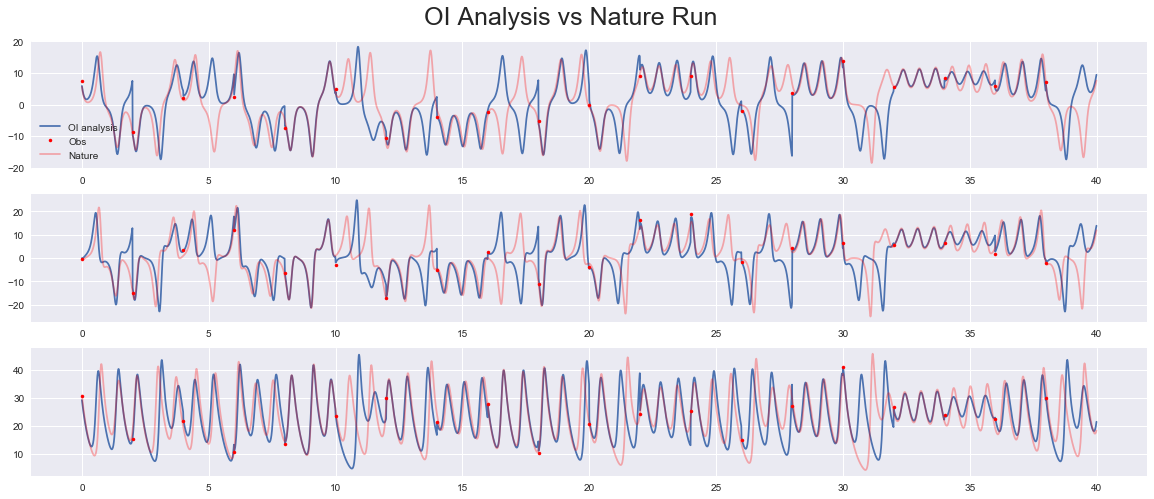

In [183]:
from assimilation_schemes import OI


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')


cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa = OI(xb, X_obs[:,[nc]], Pb, R)[0]
    x = lorenz63(xa.ravel(), ts).y
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('OI Analysis vs Nature Run', fontsize=25, y=0.94);

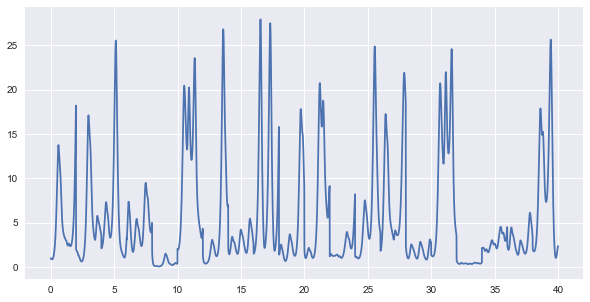

In [184]:
rmse = np.sqrt(np.mean((result-X_nature)**2, axis=0))
plt.figure(figsize=(10, 5))
plt.plot(ts, rmse)

#### (3) Kalman Filter

========Some Parameters=========
cycle length (time interval between two observations): 2 sec
number of cycle: 20
dt = 0.01 sec
initial value for experiment: [-5.37015148 -8.18451994 18.23352007]
initial value for nature run: [ 5.57925715 -0.43297528 30.89471364]


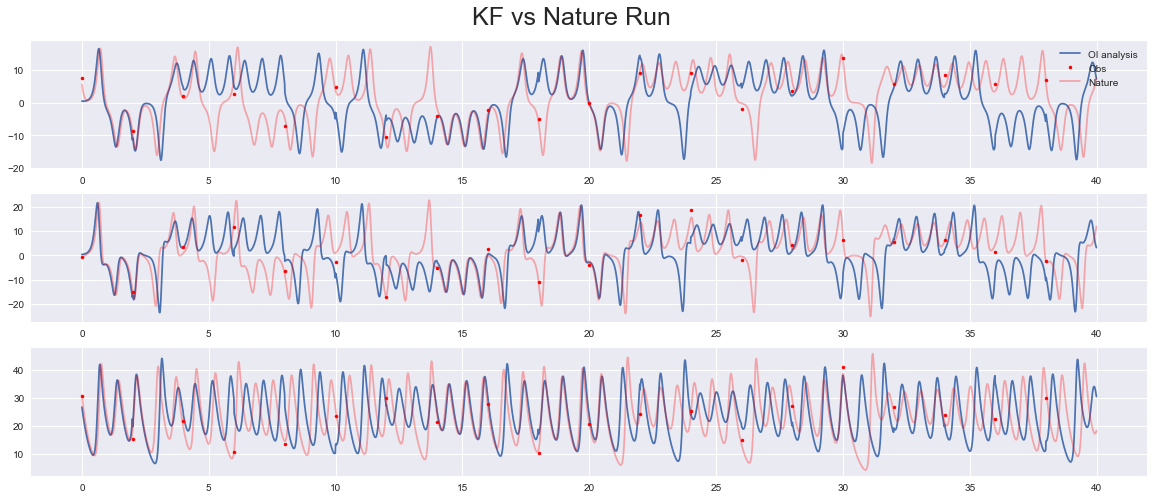

In [191]:
print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')


cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa, Pa = OI(xb, X_obs[:,[nc]], Pb, R)
    x = lorenz63(xa.ravel(), ts).y
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    Pb = Pa
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('KF vs Nature Run', fontsize=25, y=0.94);

In [238]:
Pb_nmc_noiter = np.array([
    [ 3.55388503,  5.17753847,  2.23886887],
    [ 5.17753847, 10.69676405,  3.99301979],
    [ 2.23886887,  3.99301979,  7.63994213]
])
Pb = Pb_nmc_noiter
Pb

array([[ 3.55388503,  5.17753847,  2.23886887],
       [ 5.17753847, 10.69676405,  3.99301979],
       [ 2.23886887,  3.99301979,  7.63994213]])

In [239]:
def M(xi, yi, zi, dt, sigma=10, r=28, b=8/3):
    M = np.array([
        [-sigma, sigma, 0],
        [r, -1, -xi],
        [0.5*yi, 0.5*xi, -b]
    ]) * dt
    return M

In [240]:
M(X_ini[0,0], X_ini[1,0], X_ini[2,0], dt)

array([[-0.1       ,  0.1       ,  0.        ],
       [ 0.28      , -0.01      ,  0.05370151],
       [-0.0409226 , -0.02685076, -0.02666667]])

========Some Parameters=========
cycle length (time interval between two observations): 2 sec
number of cycle: 20
dt = 0.01 sec
initial value for experiment: [-5.37015148 -8.18451994 18.23352007]
initial value for nature run: [ 5.57925715 -0.43297528 30.89471364]
=== Pb ===
[[ 3.55388503  5.17753847  2.23886887]
 [ 5.17753847 10.69676405  3.99301979]
 [ 2.23886887  3.99301979  7.63994213]]
=== Pa ===
[[1.30886851 1.14305164 0.29270162]
 [1.14305164 2.91416563 0.45646057]
 [0.29270162 0.45646057 2.82609949]]
=== Pb ===
[[ 0.01936931 -0.00553458 -0.0045137 ]
 [-0.00553458  0.11296779 -0.0297532 ]
 [-0.0045137  -0.0297532   0.01010706]]
=== Pa ===
[[ 0.01928453 -0.00541772 -0.00451939]
 [-0.00541772  0.11029697 -0.02904305]
 [-0.00451939 -0.02904305  0.00991013]]
=== Pb ===
[[ 1.40416930e-03 -1.08738466e-03 -3.82025883e-04]
 [-1.08738466e-03  1.45982333e-03 -9.14322521e-05]
 [-3.82025883e-04 -9.14322521e-05  3.47538561e-04]]
=== Pa ===
[[ 1.40350962e-03 -1.08676911e-03 -3.81911975e-04]
 [

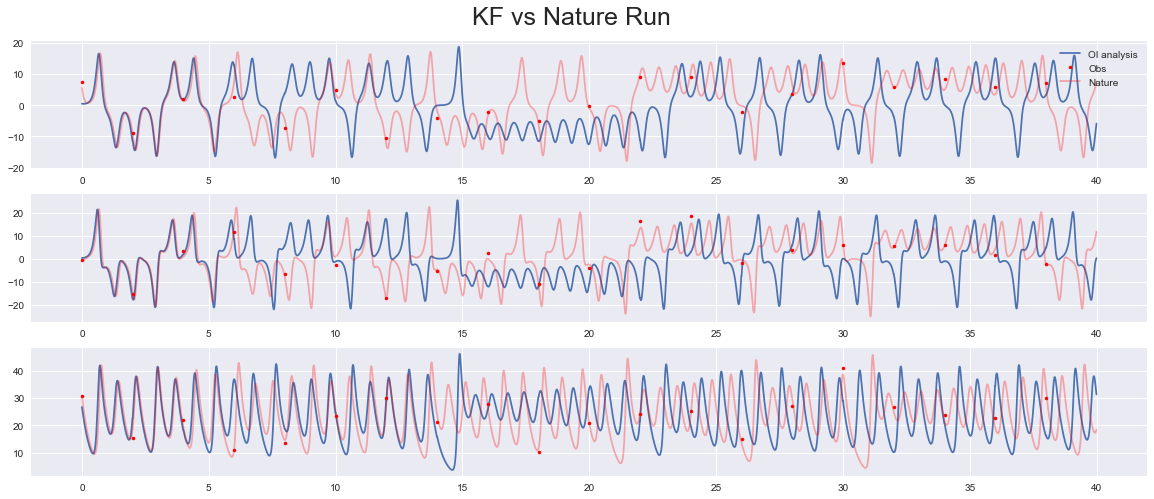

In [241]:
print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')


cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    print('=== Pb ===')
    print(Pb)
    # calculate analysis field, then forecast
    xa, Pa = OI(xb, X_obs[:,[nc]], Pb, R)
    x = lorenz63(xa.ravel(), ts).y
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
    print('=== Pa ===')
    print(Pa)
        
    # for next cycle
    Pb = M(xb[0,0], xb[1,0], xb[2,0], dt) @ Pa @ M(xb[0,0], xb[1,0], xb[2,0], dt).T
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('KF vs Nature Run', fontsize=25, y=0.94);